# Generative Adversarial Networks   (Vanilla)

> Goodfellow I, Pouget-Abadie J, Mirza M, Xu B, Warde-Farley D, Ozair S, Courville A, Bengio Yoshua

In [ ]:
import numpy as np
np.random.randint(0,32)

21

## 0A. Imports

#### **!! INTERACTIVE CELL !!**
##### wandb Logger: Needs login key!

In [ ]:
!pip -qqq install wandb pytorch-lightning torchmetrics

import wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

# API Key:
# d926baa25b6a14ffa4e5c30a6f3bbffbeca8fcf1

True

In [ ]:
# Use in case wandb fails
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#### Pytorch-Lightning (Don't open... very large installation output)

In [ ]:
try:
  import lightning.pytorch as pl
except:
  print("[!] Couldn't find pytorch-lightning.\nInstalling it...\n")
  !pip install lightning
  import lightning.pytorch as pl

[!] Couldn't find pytorch-lightning.
Installing it...

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.5/553.5 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from lightning.pytorch.utilities.model_summary import ModelSummary

#### Standard imports

In [ ]:
import os
import shutil
import pathlib

import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets

try:
    from torchinfo import summary
except:
    print("[!] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [ ]:
from torchvision.transforms import Compose, ToTensor

#### Albumentations 

In [ ]:
try:
  import albumentations as A
  from albumentations.pytorch import ToTensorV2
except:
  print("[!] Couldn't find albumentations... installing it.")
  !pip install -U albumentations
  import albumentations as A
  from albumentations.pytorch import ToTensorV2

In [ ]:
from pytorch_lightning import seed_everything

#### Torchmetrics

In [ ]:
try:
  import torchmetrics
except:
  print(f"[!] Torchmetrics couldn't be imported.\nInstalling...")
  !pip install torchmetrics

#### Seeds (lightning)

In [ ]:
seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

#### Device set up: 

In [ ]:
# device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

## 0B. Utilities

In [ ]:
# Folder Utilities ----------------------------

## Create dir if it doesn't exist
def create_dir(dir_name):
  if not os.path.exists(f'/content/{dir_name}'):
    os.mkdir(f'/content/{dir_name}')

## Delete dir: checkpoints
def delete_dir(dir_name):
  if os.path.isdir(f'/content/{dir_name}'):
    shutil.rmtree(f'/content/{dir_name}')

# ---------------------------------------------

## 1. Transforms & Datasets 

Dataset-1: FashionMNIST

#### TODO: Play around with the transforms as experiments - Report

### Transforms

In [ ]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
test_transform = A.Compose([ToTensorV2()])

### Dataset Download & Transformation

In [ ]:
train_fashion = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

train_fashion, val_fashion = random_split(train_fashion, [55000, 5000])

test_fashion = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
print("Train samples:", len(train_fashion), "| Test samples:" , len(test_fashion), "| Val samples:", len(val_fashion))

Train samples: 55000 | Test samples: 10000 | Val samples: 5000


### Sanity Visualization

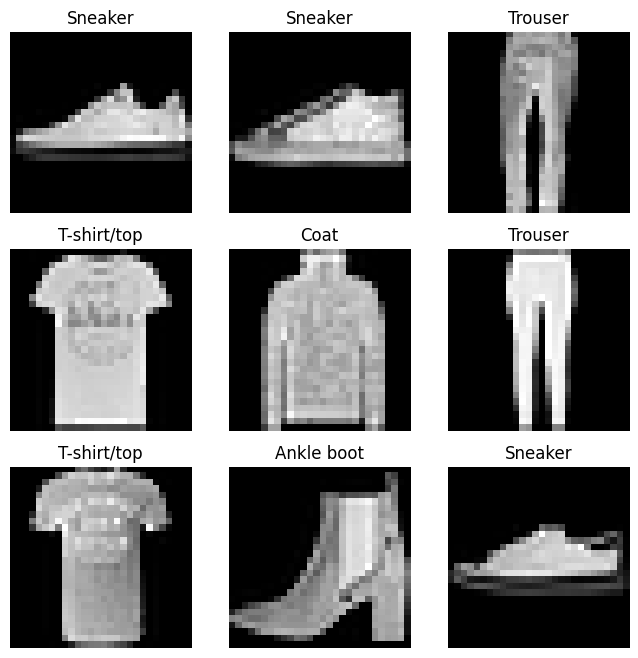

In [ ]:
labels_map = {i: x for i,x in enumerate(test_fashion.classes)}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_fashion), size=(1,)).item()
    img, label = train_fashion[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 2. Dataloader:   

Params:   
> BS: *32* , Shuffle = *True*

In [ ]:
train_dataloader = DataLoader(train_fashion, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_fashion, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_fashion, batch_size=32, shuffle=True)

## 3. Model Architecture

### Discriminator:

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, img_shape):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(int(np.prod(img_shape)), 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),   
        nn.Linear(128,1),
        nn.Sigmoid() 
    )
  
  def forward(self, x):
    x = x.view(x.size(0), -1)
    real_or_fake = self.model(x)
    return real_or_fake

### Generator:

In [ ]:
class Generator(nn.Module):
  def __init__(self, img_shape, latent_dim: int = 100):
    super().__init__()

    self.img_shape = img_shape

    # Paper says nothing about batchNorm?
    self.model = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 784),
        nn.Sigmoid()          # Implementation detail: As per paper
    )
  
  def forward(self, z):
    img = self.model(z)
    img = img.view(img.size(0), *self.img_shape)
    return img

## 4. Lightning Recipe for training & testing + Trainers

### Recipe

In [ ]:
class LIT_GAN(pl.LightningModule):
  
  def __init__(self, 
               discriminator_model, 
               generator_model, 
               latent_dim: int = 100, 
               lr: float = 0.003, 
               b1: float = 0.5, 
               b2: float = 0.999,
               disc_steps: int = 1):
    
    super().__init__()
    self.save_hyperparameters(ignore=[discriminator_model, generator_model])
    self.automatic_optimization = False

    self.discriminator = discriminator_model
    self.generator = generator_model

    self.validation_z = torch.randn(8, self.hparams.latent_dim)
  
  
  def configure_optimizers(self):
    lr = self.hparams.lr
    b1 = self.hparams.b1
    b2 = self.hparams.b2

    optim_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1,b2))
    optim_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1,b2))
    
    return [optim_g, optim_d], []


  def forward(self, z):
    return self.generator(z)


  def adv_loss(self, prob, target):
    loss = F.binary_cross_entropy(prob, target)
    return loss


  def training_step(self, batch, batch_idx):
    imgs, _ = batch
    # print(f"{batch_idx}:: imgs.shape =",imgs.shape)

    opt_g, opt_d = self.optimizers()

    z = torch.randn(imgs.shape[0], self.hparams.latent_dim) # N x Z_d
    z = z.type_as(imgs)

    fake_arr = torch.zeros(imgs.size(0), 1) # N: 0s
    real_arr = torch.ones(imgs.size(0), 1) # N: 1s
    # print(f"Disc out shape:", self.discriminator(self(z)).shape)
    # Train G:
    self.toggle_optimizer(opt_g)
    
    # Generator loss:
    g_loss = self.adv_loss(self.discriminator(self(z)), real_arr) # Fooling the Disc: How Real is the fake output?

    # Grad step:
    self.log("g_loss", g_loss, prog_bar=True)
    self.manual_backward(g_loss)
    opt_g.step()
    opt_g.zero_grad()
    self.untoggle_optimizer(opt_g)

    # Train Discriminator
    self.toggle_optimizer(opt_d)
    
    # Paper's proposition: To keep D at optimum discriminative power
    # Train it 'k' steps (h-param)
    # Experimentally k is kept at 1
    
    for i in range(self.hparams.disc_steps):
      # Discriminator loss:
      d_loss_real = self.adv_loss(self.discriminator(imgs), real_arr)
      d_loss_fake = self.adv_loss(self.discriminator(self(z)), fake_arr)
      d_loss = (d_loss_fake + d_loss_real) / 2

      self.log("d_loss", d_loss, prog_bar=True)
      self.manual_backward(d_loss)
      opt_d.step()
      opt_d.zero_grad()
    self.untoggle_optimizer(opt_d)


    self.log_dict({"g_loss": g_loss, "d_loss": d_loss}, prog_bar=True)


  def on_validation_epoch_end(self):
    z = self.validation_z.type_as(self.generator.model[0].weight)
    
    # log sampled images
    sample_imgs = self(z)
    grid = torchvision.utils.make_grid(sample_imgs)
    self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

### Recipe & trainer: initializations

In [ ]:
sample_img, sample_target = next(iter(train_dataloader))
sample_img.shape, sample_target.size()

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [ ]:
van_gan = LIT_GAN(
      Discriminator(img_shape=(sample_img.size(2), sample_img.size(3))), 
      Generator(img_shape=(sample_img.size(2), sample_img.size(3))), 
      lr=1e-3
    )
summary = ModelSummary(van_gan, max_depth=-1)
print(summary)

   | Name                  | Type          | Params
---------------------------------------------------------
0  | discriminator         | Discriminator | 566 K 
1  | discriminator.model   | Sequential    | 566 K 
2  | discriminator.model.0 | Linear        | 401 K 
3  | discriminator.model.1 | ReLU          | 0     
4  | discriminator.model.2 | Linear        | 131 K 
5  | discriminator.model.3 | ReLU          | 0     
6  | discriminator.model.4 | Linear        | 32.9 K
7  | discriminator.model.5 | ReLU          | 0     
8  | discriminator.model.6 | Linear        | 129   
9  | discriminator.model.7 | Sigmoid       | 0     
10 | generator             | Generator     | 579 K 
11 | generator.model       | Sequential    | 579 K 
12 | generator.model.0     | Linear        | 12.9 K
13 | generator.model.1     | ReLU          | 0     
14 | generator.model.2     | Linear        | 33.0 K
15 | generator.model.3     | ReLU          | 0     
16 | generator.model.4     | Linear        | 131 K 
17 | g

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'discriminator_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['discriminator_model'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'generator_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator_model'])`.
  rank_zero_warn(


In [ ]:
delete_dir("van_gan_exps")
create_dir("van_gan_exps")

In [ ]:
wandb.finish()

In [ ]:
wandb_logger = WandbLogger(project="DIP", name="full-sanity-exp-1")

In [ ]:
# train model
from lightning.pytorch.callbacks import DeviceStatsMonitor, TQDMProgressBar

trainer = pl.Trainer(default_root_dir="/content/van_gan_exps/", 
                     fast_dev_run=False,
                     logger=wandb_logger,   # wandb <3
                     log_every_n_steps=1,   # set the logging frequency
                     accelerator='auto',
                     devices="auto",        # all
                     max_epochs=5,          # number of epochs
                     deterministic=True,    # keep it deterministic
                     callbacks=[TQDMProgressBar(refresh_rate=10)],
                     )

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


#### Training:

In [ ]:
# Train model:
trainer.fit(van_gan, train_dataloader, val_dataloader)

INFO: 
  | Name          | Type          | Params
------------------------------------------------
0 | discriminator | Discriminator | 566 K 
1 | generator     | Generator     | 579 K 
------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.584     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | discriminator | Discriminator | 566 K 
1 | generator     | Generator     | 579 K 
------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.584     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
wandb.finish()

## 5. Evaluation + Synthesized: Printing & Display?
